In [1]:
import cv2
import mediapipe as mp
import numpy as np
import math
import matplotlib.pyplot as plt
import os
from scipy.signal import argrelextrema, savgol_filter
import pandas as pd

In [2]:
def visualize_motion(landmarks):
    plt.plot([i for i in range(len(landmarks))], landmarks)
    plt.show()

def extract_motion(video_path, debug=False):
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(static_image_mode=False, model_complexity=1, smooth_landmarks=True, min_detection_confidence=0.5, 
                        min_tracking_confidence=0.5)
    
    global FPS, FRAME_W, FRAME_H
    cap = cv2.VideoCapture(video_path)
    FPS = int(cap.get(cv2.CAP_PROP_FPS))
    # FRAME_W = int(cap.get(3)) 
    # FRAME_H = int(cap.get(4))
    FRAME_W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    FRAME_H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    landmarks = []
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        try:
            results = pose.process(frame)
            landmark = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER]
            landmarks.append(landmark.y)
            frames.append(frame)
        except:
            continue

    cap.release()

    if debug:
        visualize_motion(landmarks)

    return landmarks, frames

### Automated Rep Segmentation (Unstable)

In [3]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def segment_video_into_reps(video_path, save_path, debug=False):
    landmarks, frames = extract_motion(video_path, True)

    ref_pt = landmarks[0]
    # min_idxs = argrelextrema(savgol_filter(np.array(landmarks), FPS, 5), np.less, order=FPS)[0]
    min_idxs = argrelextrema(smooth(np.array(landmarks), FPS), np.less, order=FPS)[0]
    chg_pt_idxs = [chg_pt for chg_pt in min_idxs if chg_pt > FPS*2 and chg_pt < (len(landmarks) - FPS)]
    if debug:
        print(chg_pt_idxs)

    rep_count = 0
    video_writer = cv2.VideoWriter(f"{save_path}_seg{rep_count+1}.mp4", cv2.VideoWriter_fourcc(*'MP4V'), FPS, (FRAME_W, FRAME_H))
    for i, frame in enumerate(frames):
        video_writer.write(frame) 
        try:
            if i == chg_pt_idxs[rep_count]:
                if debug:
                    print(ref_pt, landmarks[i])
                rep_count += 1
                # if rep_count == len(chg_pt_idxs):
                #     break
                
                video_writer = cv2.VideoWriter(f"{save_path}_seg{rep_count+1}.mp4", cv2.VideoWriter_fourcc(*'MP4V'), FPS, (FRAME_W, FRAME_H))
        except:
            continue    
            
    video_writer.release()

In [97]:
og_data_folder = '../data/Kinetics700'
new_data_folder = '../data/rep_data'

og_data_files = os.listdir(og_data_folder)
for i in range(0, len(og_data_files)):
    file_basename = og_data_files[i].split('.')[0]
    video_path = os.path.join(og_data_folder, f"{file_basename}.mp4")
    save_path = os.path.join(new_data_folder, f"vid{i+7}")
    
    segment_video_into_reps(video_path, save_path, True)

### Manual Rep Segmentation

In [ ]:
og_data_folder = '../data/Kinetics700'
new_data_folder = '../data/rep_data'

In [296]:
### START HERE ###
# Update file name
file_name = ''

# Increment number for every new file to follow proper naming convention
i = 45
video_path = os.path.join(og_data_folder, file_name)
save_path = os.path.join(new_data_folder, f"vid{i+7}")

c:\Users\aravp\AppData\Local\Programs\Python\Python310\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


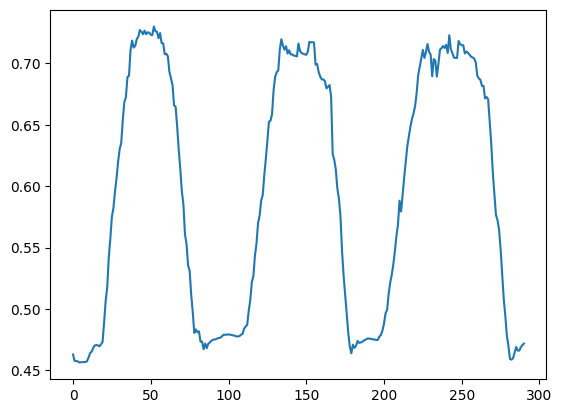

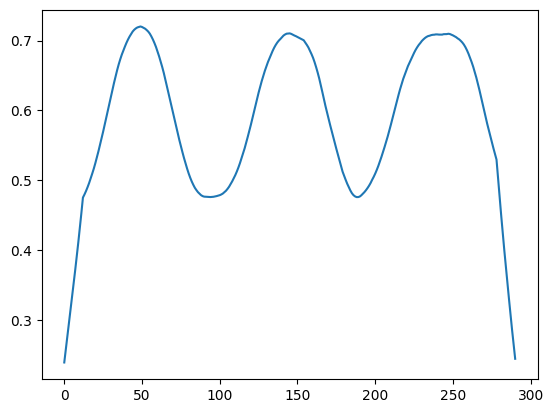

In [6]:
# Get video frames and left shoulder position per frame
# Visualize raw vs. smoothed motion curves
landmarks, frames = extract_motion(video_path, True)
visualize_motion(smooth(np.array(landmarks), FPS))

In [300]:
# Use visualization above to manually verify local minima (i.e. changepoints for splitting video)
# If suboptimal, uncomment one of following to determine optimal method for finding local minima
# Also try changing order parameter or other parameters in smoothing functions

min_idxs = argrelextrema(np.array(landmarks), np.less, order=10)[0]
#min_idxs = argrelextrema(savgol_filter(np.array(landmarks), FPS, 5), np.less, order=FPS)[0]
#min_idxs = argrelextrema(smooth(np.array(landmarks), FPS), np.less, order=FPS)[0]
print(min_idxs)

# Eliminate potentially extraneous changepoints (i.e. points too close to start/end of video)
# If suboptimal, ignore removed changepoints and set chg_pt_idxs = min_idxs
chg_pt_idxs = [chg_pt for chg_pt in min_idxs if chg_pt > FPS and chg_pt < (len(landmarks) - FPS)]
chg_pt_idxs 

[ 21  44  64  84 107 128 148 169 190 212 232 255 275]


In [301]:
# Automate rep segmentation based on changepoints determined above
rep_count = 0
video_writer = cv2.VideoWriter(f"{save_path}_seg{rep_count+1}.mp4", cv2.VideoWriter_fourcc(*'MP4V'), FPS, (FRAME_W, FRAME_H))
for i, frame in enumerate(frames):
    video_writer.write(frame) 
    try:
        if i == chg_pt_idxs[rep_count]:
            rep_count += 1
            video_writer = cv2.VideoWriter(f"{save_path}_seg{rep_count+1}.mp4", cv2.VideoWriter_fourcc(*'MP4V'), FPS, (FRAME_W, FRAME_H))
    except:
        continue    
        
video_writer.release()

### Manual Label Annotation

In [40]:
l = []

In [17]:
# Set labels for single video case
d = {}
d['Video_ID'] = 'vid49_seg1.mp4'
d['Improper_Depth'] = 1
d['Flared_Elbows'] = 0
d['Sagged_Back'] = 1
d['Arched_Back'] = 0
d['Extended_Hands'] = 0
d['Wide_Hands'] = 1
d['Sagged_Knees'] = 1
d['Neutral_Neck'] = 0
d['Wide_Feet'] = 0
d['Too_Fast'] = 0
d['Smooth_Motion'] = 1
l.append(d)

In [302]:
# Set labels for multi-video case; change range according to number of video segments
for i in range(1, 15):
    d = {}
    d['Video_ID'] = f'vid51_seg{i}.mp4'
    d['Improper_Depth'] = 0
    d['Flared_Elbows'] = 0
    d['Sagged_Back'] = 0
    d['Arched_Back'] = 0
    d['Extended_Hands'] = 0
    d['Wide_Hands'] = 1
    d['Sagged_Knees'] = 0
    d['Neutral_Neck'] = 1
    d['Wide_Feet'] = 0
    d['Too_Fast'] = 1
    d['Smooth_Motion'] = 1
    l.append(d)

In [158]:
df = pd.DataFrame(l)
print(len(df))
df.to_csv('../data/rep_data2/annotations.csv')

99
